# **UAS Big Data & Predictive Analytics Lanjut**

Topik: Prediksi Keterlambatan Penerbangan

Tujuan: Memahami faktor-faktor yang memengaruhi keterlambatan penerbangan, seperti cuaca, bandara asal, dan waktu keberangkatan.

Alasan: Dengan meningkatnya jumlah penumpang udara, masalah ini menjadi perhatian utama industri penerbangan.

Dataset : https://drive.google.com/drive/folders/17cP2YjGWGUDHgQeOYY404cNP7D7ZdDa2?usp=sharing

**JUDUL : Analisis dan Penerapan Empat Model Machine Learning untuk Prediksi Penundaan Penerbangan Berdasarkan Faktor Cuaca dan Waktu Keberangkatan.**

Anggota Kelompok :


1.   Nadia Martha Lefi (22.11.5140)
1.   Hasna Almaas Tristo (22.11.5187)
3.   Bryantnata Imam Safi'i (22.11.4763)
4.   M Jidan Amir (22.11.4765)








# **IMPORT LIBRARY**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, to_date, hour, dayofweek, month
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.stat import Correlation
from pyspark.ml.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**LOAD DATA & EXPLORE DATA**

In [4]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Flights Delay Classification") \
    .getOrCreate()

flights_df = spark.read.csv('/content/drive/MyDrive/BIGDATA LANJUT/UAS/dataset_flight/Prepro_US_flights_2023.csv', header=True)
weather_df = spark.read.csv('/content/drive/MyDrive/BIGDATA LANJUT/UAS/dataset_flight/weather_meteo_by_airport.csv', header=True)
location_df = spark.read.csv('/content/drive/MyDrive/BIGDATA LANJUT/UAS/dataset_flight/airports_geolocation.csv', header=True)


In [5]:
# Menampilkan nama kolom pada flights_df
print("Kolom dalam flights_df:", flights_df.columns)

# Menampilkan nama kolom pada weather_df
print("Kolom dalam weather_df:", weather_df.columns)

# Menampilkan nama kolom pada location_df
print("Kolom dalam location_df:", location_df.columns)


Kolom dalam flights_df: ['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay', 'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Manufacturer', 'Model', 'Aicraft_age']
Kolom dalam weather_df: ['time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'airport_id']
Kolom dalam location_df: ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE']


#Preprocessing

In [6]:
from pyspark.sql.types import FloatType
# Pilih kolom yang relevan untuk flights
flights_df = flights_df.select(
    'FlightDate', 'Day_Of_Week', 'Airline', 'Dep_Airport', 'DepTime_label', 'Dep_Delay',
    'Dep_Delay_Tag', 'Arr_Airport', 'Arr_Delay', 'Flight_Duration', 'Distance_type',
    'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft'
)

# Pilih kolom yang relevan untuk weather
weather_df = weather_df.select('time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'airport_id')

# Pilih kolom yang relevan untuk location
location_df = location_df.select('IATA_CODE', 'LATITUDE', 'LONGITUDE')


In [7]:
# Join flights data with weather data on Dep_Airport and airport_id
flights_weather_df = flights_df.join(weather_df, flights_df.Dep_Airport == weather_df.airport_id, how='left')

# Join with location data to include geolocation
flights_weather_loc_df = flights_weather_df.join(location_df, flights_weather_df.Dep_Airport == location_df.IATA_CODE, how='left')


In [8]:
# Konversi kolom tanggal
flights_weather_loc_df = flights_weather_loc_df.withColumn("FlightDate", to_date(col("FlightDate"), "yyyy-MM-dd"))
flights_weather_loc_df = flights_weather_loc_df.withColumn("time", to_date(col("time"), "yyyy-MM-dd"))


# Konversi kolom numerik
flights_weather_loc_df = flights_weather_loc_df.withColumn("Dep_Delay", col("Dep_Delay").cast(FloatType()))
flights_weather_loc_df = flights_weather_loc_df.withColumn("Arr_Delay", col("Arr_Delay").cast(FloatType()))
flights_weather_loc_df = flights_weather_loc_df.withColumn("Flight_Duration", col("Flight_Duration").cast(FloatType()))


In [9]:
# Tambah fitur biner untuk cuaca buruk
flights_weather_loc_df = flights_weather_loc_df.withColumn(
    "Severe_Weather",
    when(col("prcp") > 0.1, 1).otherwise(0)
)

In [10]:
# Remove invalid records (e.g., negative delays)
flights_weather_loc_df = flights_weather_loc_df.filter((col("Flight_Duration") > 0) & (col("Dep_Delay") >= 0))

**CEK TIPE DATA**

In [11]:
print("Data Schema:")
flights_weather_loc_df.printSchema()

Data Schema:
root
 |-- FlightDate: date (nullable = true)
 |-- Day_Of_Week: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Dep_Airport: string (nullable = true)
 |-- DepTime_label: string (nullable = true)
 |-- Dep_Delay: float (nullable = true)
 |-- Dep_Delay_Tag: string (nullable = true)
 |-- Arr_Airport: string (nullable = true)
 |-- Arr_Delay: float (nullable = true)
 |-- Flight_Duration: float (nullable = true)
 |-- Distance_type: string (nullable = true)
 |-- Delay_Carrier: string (nullable = true)
 |-- Delay_Weather: string (nullable = true)
 |-- Delay_NAS: string (nullable = true)
 |-- Delay_Security: string (nullable = true)
 |-- Delay_LastAircraft: string (nullable = true)
 |-- time: date (nullable = true)
 |-- tavg: string (nullable = true)
 |-- tmin: string (nullable = true)
 |-- tmax: string (nullable = true)
 |-- prcp: string (nullable = true)
 |-- snow: string (nullable = true)
 |-- wspd: string (nullable = true)
 |-- pres: string (nullable = true)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
flights_weather_loc_df.show(5)

+----------+-----------+------------+-----------+-------------+---------+-------------+-----------+---------+---------------+------------------+-------------+-------------+---------+--------------+------------------+----------+----+----+----+----+----+----+------+----------+---------+--------+---------+--------------+
|FlightDate|Day_Of_Week|     Airline|Dep_Airport|DepTime_label|Dep_Delay|Dep_Delay_Tag|Arr_Airport|Arr_Delay|Flight_Duration|     Distance_type|Delay_Carrier|Delay_Weather|Delay_NAS|Delay_Security|Delay_LastAircraft|      time|tavg|tmin|tmax|prcp|snow|wspd|  pres|airport_id|IATA_CODE|LATITUDE|LONGITUDE|Severe_Weather|
+----------+-----------+------------+-----------+-------------+---------+-------------+-----------+---------+---------------+------------------+-------------+-------------+---------+--------------+------------------+----------+----+----+----+----+----+----+------+----------+---------+--------+---------+--------------+
|2023-01-11|          3|Endeavor Air|   

**RENAME**

In [14]:
flights_weather_loc_df = flights_weather_loc_df.withColumnRenamed("Unnamed: 0", "Index") \
                                               .withColumnRenamed("Dep_CityName", "Departure_City") \
                                               .withColumnRenamed("Arr_CityName", "Arrival_City") \
                                               .withColumnRenamed("Dep_Airport", "Departure_Airport") \
                                               .withColumnRenamed("Arr_Airport", "Arrival_Airport") \
                                               .withColumnRenamed("Dep_Delay_Tag", "Delay_Tag") \
                                               .withColumnRenamed("Dep_Delay_Type", "Delay_Type") \
                                               .withColumnRenamed("FlightDate", "Date") \
                                               .withColumnRenamed("IATA_CODE", "Airport_Code")

**MELIHAT JUMLAH NILAI NULL**

In [15]:
from pyspark.sql import functions as F
from IPython.display import display

null_counts = flights_weather_loc_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in flights_weather_loc_df.columns]).toPandas()
print("Jumlah nilai null per kolom:")
display(null_counts)

Jumlah nilai null per kolom:


,Date,Day_Of_Week,Airline,Departure_Airport,DepTime_label,Dep_Delay,Delay_Tag,Arrival_Airport,Arr_Delay,Flight_Duration,...,tmax,prcp,snow,wspd,pres,airport_id,Airport_Code,LATITUDE,LONGITUDE,Severe_Weather
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**UBAH TIPE DATA**

In [16]:
flights_weather_loc_df = flights_weather_loc_df.withColumn("tavg", col("tavg").cast("float")) \
                                               .withColumn("tmin", col("tmin").cast("float")) \
                                               .withColumn("tmax", col("tmax").cast("float")) \
                                               .withColumn("prcp", col("prcp").cast("float")) \
                                               .withColumn("snow", col("snow").cast("float")) \
                                               .withColumn("wspd", col("wspd").cast("float")) \
                                               .withColumn("pres", col("pres").cast("float"))

flights_weather_loc_df = flights_weather_loc_df.withColumn("Severe_Weather", col("Severe_Weather").cast("boolean"))
flights_weather_loc_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Day_Of_Week: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Departure_Airport: string (nullable = true)
 |-- DepTime_label: string (nullable = true)
 |-- Dep_Delay: float (nullable = true)
 |-- Delay_Tag: string (nullable = true)
 |-- Arrival_Airport: string (nullable = true)
 |-- Arr_Delay: float (nullable = true)
 |-- Flight_Duration: float (nullable = true)
 |-- Distance_type: string (nullable = true)
 |-- Delay_Carrier: string (nullable = true)
 |-- Delay_Weather: string (nullable = true)
 |-- Delay_NAS: string (nullable = true)
 |-- Delay_Security: string (nullable = true)
 |-- Delay_LastAircraft: string (nullable = true)
 |-- time: date (nullable = true)
 |-- tavg: float (nullable = true)
 |-- tmin: float (nullable = true)
 |-- tmax: float (nullable = true)
 |-- prcp: float (nullable = true)
 |-- snow: float (nullable = true)
 |-- wspd: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- airport_id: str

**MENAMPILKAN SUMMARY**

In [17]:
# Ambil kolom dengan tipe numerik
numeric_columns = [field.name for field in flights_weather_loc_df.schema.fields if field.dataType.typeName() in ["float", "integer"]]

# Lakukan describe hanya pada kolom numerik
flights_weather_loc_df.select(numeric_columns).describe().show()

+-------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|         Dep_Delay|        Arr_Delay|   Flight_Duration|             tavg|             tmin|             tmax|             prcp|              snow|              wspd|              pres|
+-------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
|  count|            235790|           235790|            235790|           235790|           235790|           235790|           235790|            235790|            235790|            235790|
|   mean|48.130030959752325|45.04489164086687|112.28018575851394|14.21909113956572|9.522664659949257|19.10582660586217|3.169269251716749|6.7924509097077905|12.363838800993062|1016.2026249411573|
| stddev| 81.135604040397

In [18]:
# Menggabungkan fitur numerik menggunakan VectorAssembler
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_with_features = assembler.transform(flights_weather_loc_df)

**MENAMPILKAN MATRIKS KORELASI**

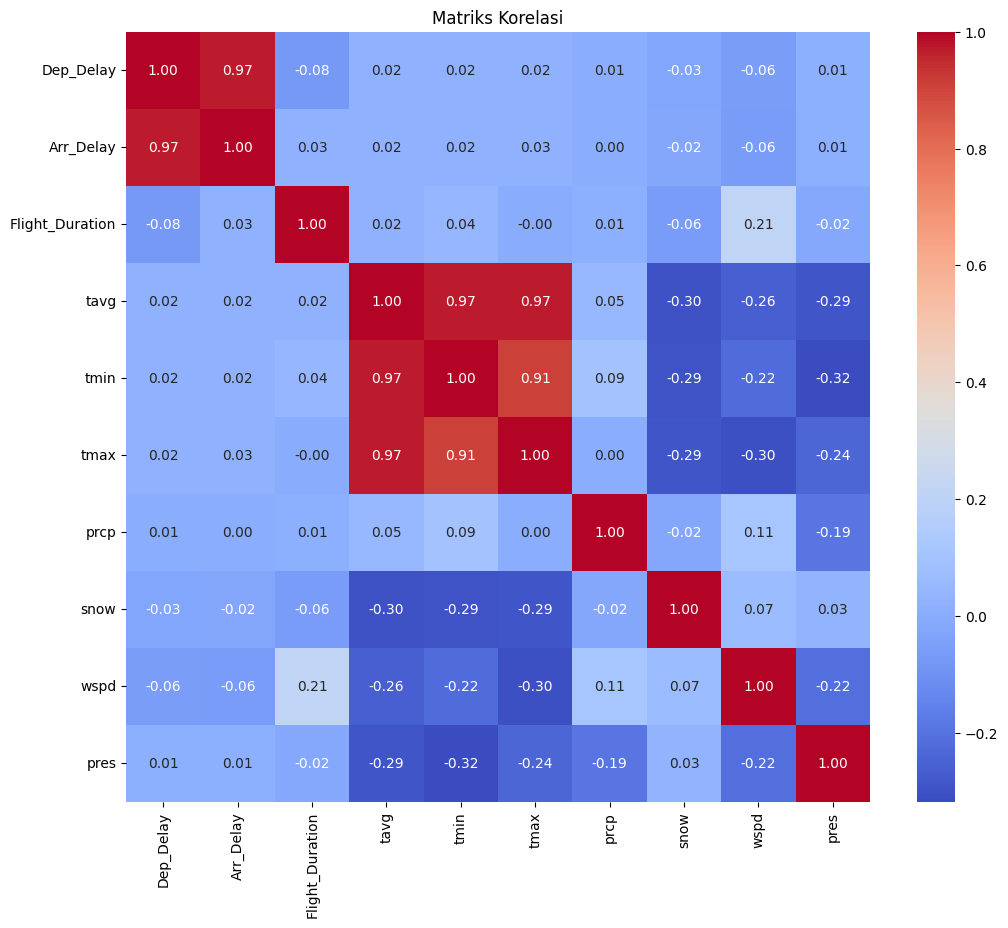

In [19]:
# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(df_with_features, "features").head()[0]
correlation_values = correlation_matrix.toArray()

# Membuat DataFrame pandas untuk visualisasi
correlation_df = pd.DataFrame(correlation_values, columns=numeric_columns, index=numeric_columns)

# Menampilkan matriks korelasi sebagai heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

In [20]:
# Encoding kolom target menjadi biner
flights_weather_loc_df = flights_weather_loc_df.withColumn(
    "label",
    when(col("Dep_Delay") < 15, 0).otherwise(1)
)


In [21]:
# Melihat distribusi kelas
flights_weather_loc_df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|141985|
|    0| 93805|
+-----+------+



In [22]:
string_cols = [
    "Day_Of_Week", "Airline", "Departure_Airport", "DepTime_label", "Delay_Tag",
    "Arrival_Airport", "Distance_type", "Delay_Carrier", "Delay_Weather",
    "Delay_NAS", "Delay_Security", "Delay_LastAircraft", "airport_id", "Airport_Code"
]

# Hapus kolom output jika sudah ada
for col_name in string_cols:
    output_col = f"{col_name}_index"
    if output_col in flights_weather_loc_df.columns:
        flights_weather_loc_df = flights_weather_loc_df.drop(output_col)

# StringIndexer untuk semua kolom string
for col_name in string_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    flights_weather_loc_df = indexer.fit(flights_weather_loc_df).transform(flights_weather_loc_df)


In [23]:
# Pilih kolom numerik dan hasil encoding sebagai fitur
numeric_cols = [
    "Dep_Delay", "Arr_Delay", "Flight_Duration", "tavg", "tmin", "tmax",
    "prcp", "snow", "wspd", "pres"
]

encoded_cols = [f"{col}_index" for col in string_cols]  # Kolom hasil encoding

feature_cols = numeric_cols + encoded_cols

# Buat fitur menggunakan VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
flights_weather_loc_df = assembler.transform(flights_weather_loc_df).select("features", "label")


In [24]:
# Split Data
train, test = flights_weather_loc_df.randomSplit([0.8, 0.2], seed=42)

In [25]:
# Cek distribusi kelas di training dan testing
train.groupBy("label").count().show()
test.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|113488|
|    0| 74900|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|28497|
|    0|18905|
+-----+-----+



#EDA

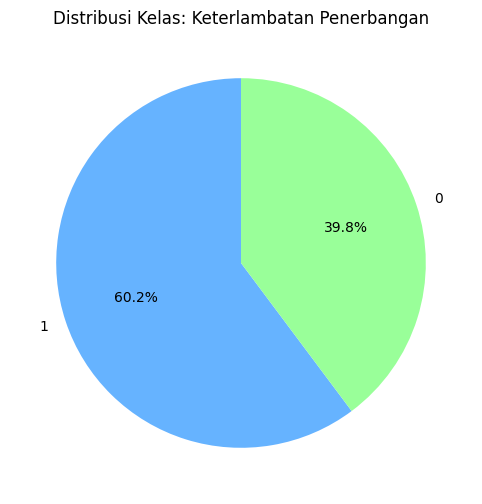

In [26]:
import matplotlib.pyplot as plt

# Ambil distribusi kelas
label_counts = flights_weather_loc_df.groupBy("label").count().toPandas()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts['count'], labels=label_counts['label'], autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#99ff99"])
plt.title("Distribusi Kelas: Keterlambatan Penerbangan")
plt.show()


In [27]:
!pip install plotly
import plotly.graph_objects as go # Import modul plotly.graph_objects

flights_weather_loc_df = spark.read.csv('/content/drive/MyDrive/BIGDATA LANJUT/UAS/dataset_flight/Prepro_US_flights_2023.csv', header=True)

# Calculate average departure and arrival delays for each period of the day based on DepTime_label
# Use the agg function with F.mean for calculating the average Dep_Delay and Arr_Delay
dep_label = flights_weather_loc_df.groupBy("DepTime_label").agg(F.mean("Dep_Delay").alias("avg(Dep_Delay)")).toPandas()
arr_label = flights_weather_loc_df.groupBy("DepTime_label").agg(F.mean("Arr_Delay").alias("avg(Arr_Delay)")).toPandas()

# mengurutkan data berdasarkan periode yang ditentukan (Pagi, Siang, Sore, Malam)
period_order = ["Morning", "Afternoon", "Evening", "Night"]
dep_label = dep_label.sort_values(by="DepTime_label", key=lambda x: x.map({day: i for i, day in enumerate(period_order)}))
arr_label = arr_label.sort_values(by="DepTime_label", key=lambda x: x.map({day: i for i, day in enumerate(period_order)}))

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=dep_label["DepTime_label"],
        y=dep_label["avg(Dep_Delay)"],
        name='Average Departure Delay',
        marker_color='blue'
    )
)

fig.add_trace(
    go.Bar(
        x=arr_label["DepTime_label"],
        y=arr_label["avg(Arr_Delay)"],
        name='Average Arrival Delay',
        marker_color='red'
    )
)

fig.update_layout(
    title_text="Average Departure and Arrival Delays by Time of Day",
    xaxis_title="Time of Day",
    yaxis_title="Delay (min)",
    barmode='group',
    legend_title="Delay Type",
    xaxis=dict(tickmode='array', tickvals=dep_label["DepTime_label"].unique())
)

fig.show()

In [28]:
from pyspark.sql import functions as F
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate average departure and arrival delays for each period of the day based on DepTime_label
# Use the agg function with F.mean for calculating the average Dep_Delay and Arr_Delay
dep_label = flights_weather_loc_df.groupBy("DepTime_label").agg(F.mean("Dep_Delay").alias("avg(Dep_Delay)")).toPandas()
arr_label = flights_weather_loc_df.groupBy("DepTime_label").agg(F.mean("Arr_Delay").alias("avg(Arr_Delay)")).toPandas()

# Mengurutkan data berdasarkan periode yang ditentukan (Pagi, Siang, Sore, Malam)
period_order = ["Morning", "Afternoon", "Evening", "Night"]
dep_label = dep_label.sort_values(by="DepTime_label", key=lambda x: x.map({day: i for i, day in enumerate(period_order)}))
arr_label = arr_label.sort_values(by="DepTime_label", key=lambda x: x.map({day: i for i, day in enumerate(period_order)}))

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=dep_label["DepTime_label"], y=dep_label["avg(Dep_Delay)"],
               mode='lines+markers', name='Departure Delay')
)

fig.add_trace(
    go.Scatter(x=arr_label["DepTime_label"], y=arr_label["avg(Arr_Delay)"],
               mode='lines+markers', name='Arrival Delay')
)

fig.update_layout(
    title_text="Departure and Arrival Delays throughout the Day",
    xaxis_title="Time of Day",
    yaxis_title="Delay (min)",
    legend_title="Delay Type"
)

fig.show()

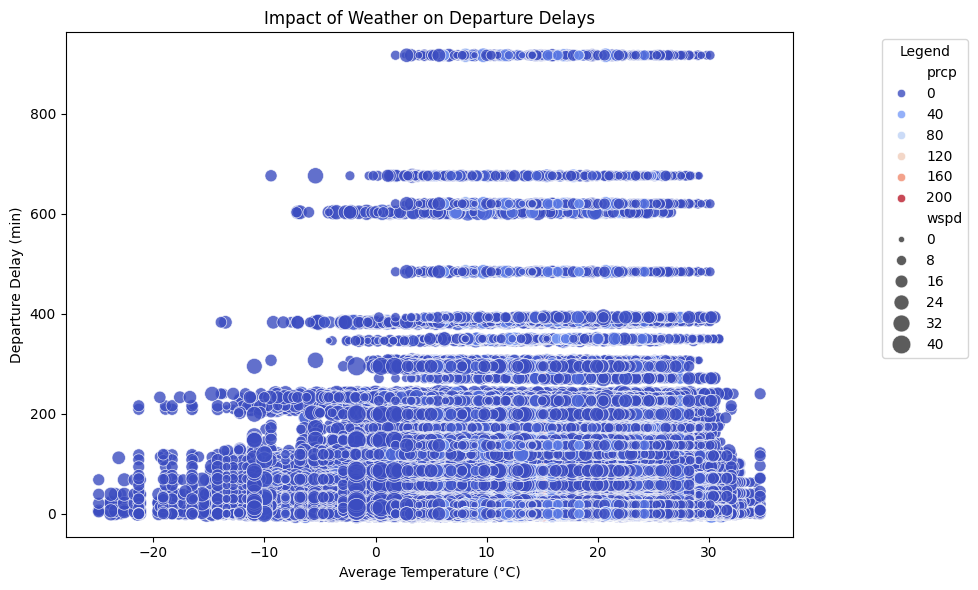

In [29]:
# Mengubah kolom yang relevan menjadi Pandas DataFrame
df_cleaned = df_with_features.select("tavg", "Dep_Delay", "prcp", "wspd").toPandas()

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=df_cleaned, x="tavg", y="Dep_Delay", hue="prcp", size="wspd", alpha=0.8,
                          sizes=(20, 200), palette="coolwarm", legend="auto")

scatter.set_title("Impact of Weather on Departure Delays")
scatter.set_xlabel("Average Temperature (°C)")
scatter.set_ylabel("Departure Delay (min)")

plt.legend(title="Legend", loc="upper right", bbox_to_anchor=(1.25, 1))

plt.tight_layout()
plt.show()

In [30]:
from pyspark.sql import functions as F
import plotly.express as px

# Membuat ulang DataFrame dengan kolom asli
flights_weather_loc_df = spark.read.csv('/content/drive/MyDrive/BIGDATA LANJUT/UAS/dataset_flight/Prepro_US_flights_2023.csv', header=True)

# Hitung rata-rata penundaan keberangkatan untuk setiap bandara (karena OriginState tidak tersedia)
state_delay = flights_weather_loc_df.groupBy('Dep_Airport').agg(F.mean('Dep_Delay').alias('Avg_Dep_Delay')).toPandas()

fig10 = px.choropleth(state_delay,
                      locations='Dep_Airport',
                      color='Avg_Dep_Delay',
                      color_continuous_scale='Viridis',
                      title="Flight Delays by Airport",
                      labels={'Avg_Dep_Delay': 'Average Departure Delay (min)'})

fig10.show()


#Model

In [31]:
from sklearn.metrics import confusion_matrix
!pip install scikit-learn
from sklearn.metrics import roc_curve, auc

Training RandomForestClassifier...
RandomForestClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



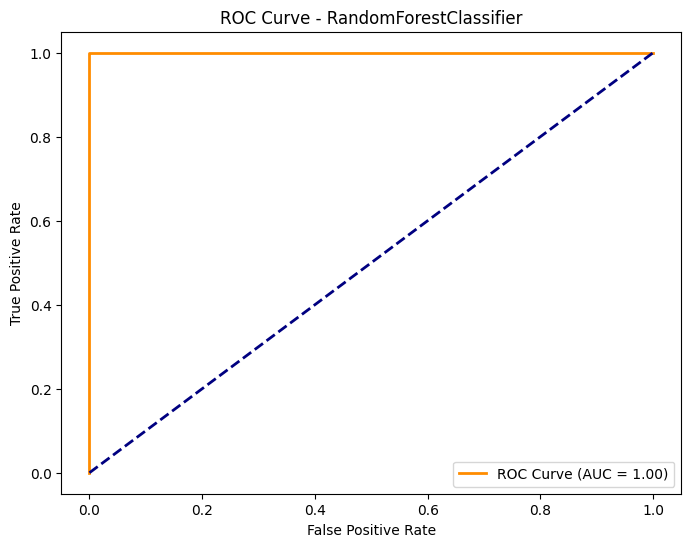

RandomForestClassifier AUC: 1.00
----------------------------------------
Training GradientBoostingClassifier...
GradientBoostingClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



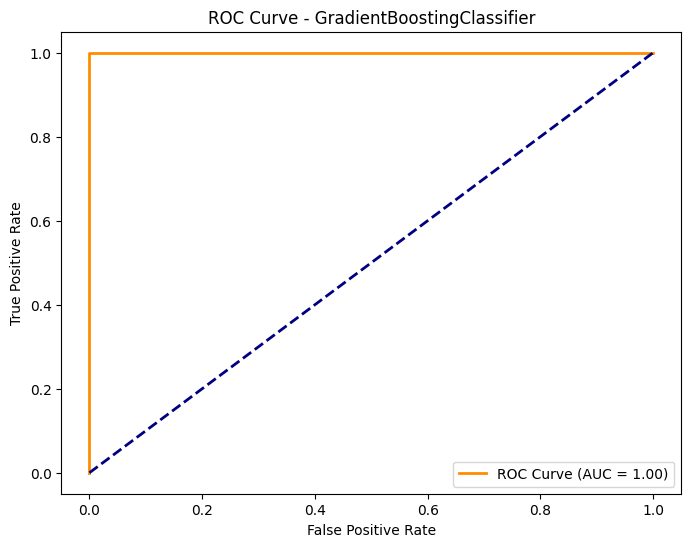

GradientBoostingClassifier AUC: 1.00
----------------------------------------
Training AdaBoostClassifier...
AdaBoostClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



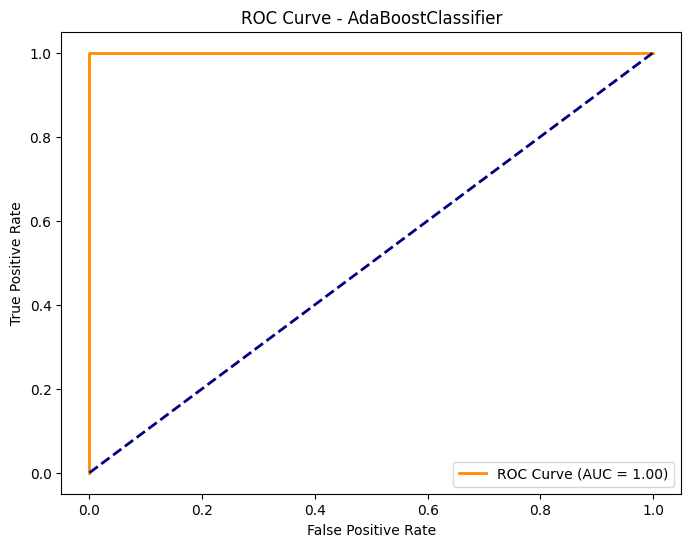

AdaBoostClassifier AUC: 1.00
----------------------------------------
Training BaggingClassifier...
BaggingClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



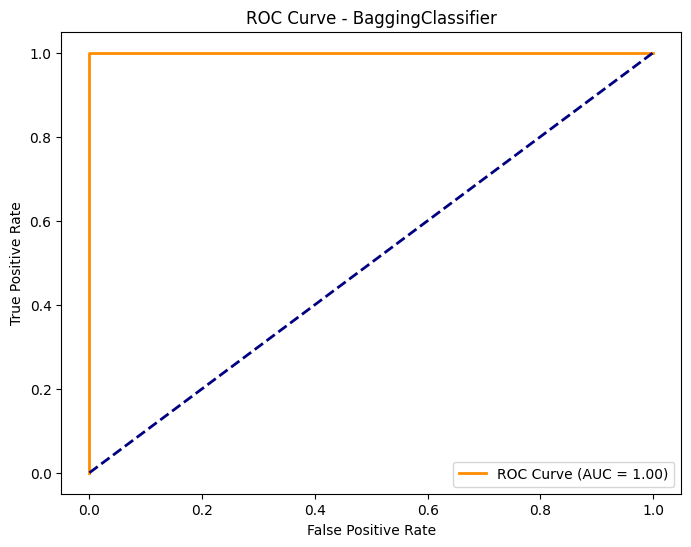

BaggingClassifier AUC: 1.00
----------------------------------------


In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

train_pd = train.toPandas()
test_pd = test.toPandas()

X_train = train_pd["features"].apply(lambda x: x.toArray()).tolist()
y_train = train_pd["label"].values.astype(int)
X_test = test_pd["features"].apply(lambda x: x.toArray()).tolist()
y_test = test_pd["label"].values.astype(int)

# Model Training dan Evaluasi
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "BaggingClassifier": BaggingClassifier(random_state=42),

}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    print(f"{model_name} AUC: {roc_auc:.2f}")
    print("-" * 40)


Evaluating RandomForestClassifier...
RandomForestClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



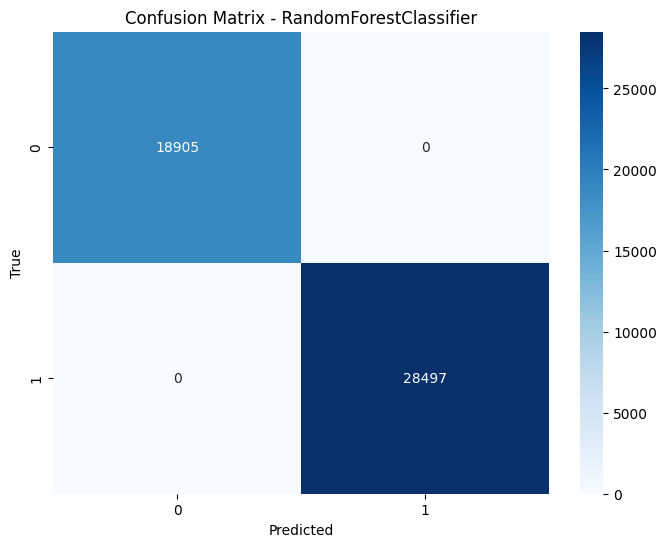

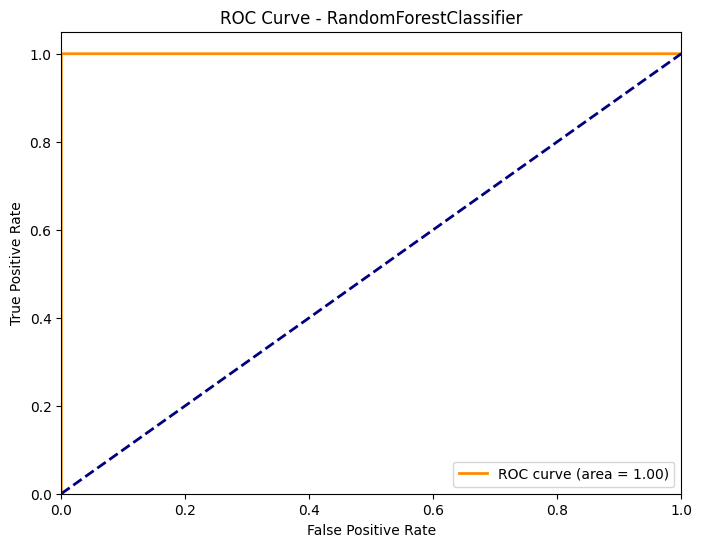

----------------------------------------
Evaluating GradientBoostingClassifier...
GradientBoostingClassifier Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     28497

    accuracy                           1.00     47402
   macro avg       1.00      1.00      1.00     47402
weighted avg       1.00      1.00      1.00     47402



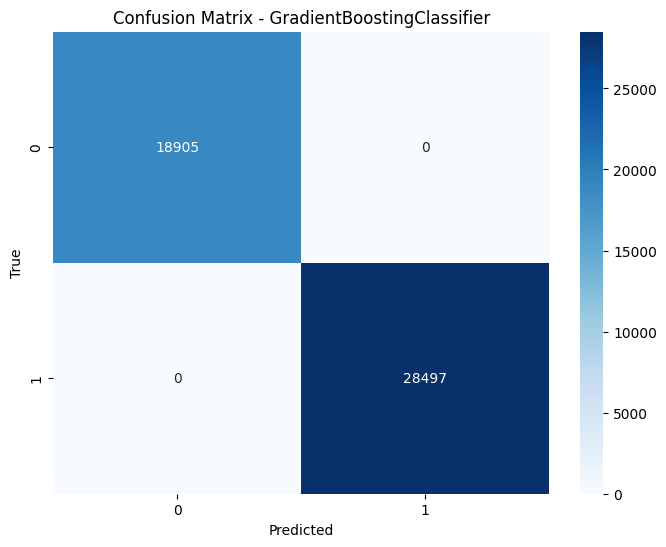

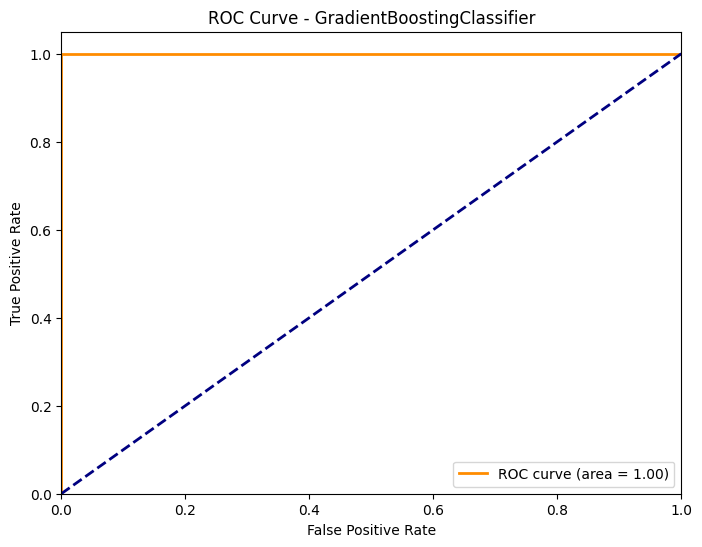

----------------------------------------


In [33]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

rf_halving_search = HalvingGridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
rf_halving_search.fit(X_train, y_train)

gb_halving_search = HalvingGridSearchCV(gb_model, param_grid_gb, cv=5, scoring='accuracy')
gb_halving_search.fit(X_train, y_train)

best_rf_model = rf_halving_search.best_estimator_
best_gb_model = gb_halving_search.best_estimator_

# Evaluasi model terbaik
models = {
    "RandomForestClassifier": best_rf_model,
    "GradientBoostingClassifier": best_gb_model
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    print("-" * 40)
